
## **1.Data Cleaning**
#### **Why you think the values are missing?**
###### **1. Column name contains "Part" is the option of multiple choice, missing values in those columns may be indicate that interviewee didn't choose those option. So it's reasonable to have missing values in columns named with "Part".**
###### **2. Some interviewee didn't answer some question and that would leading to some missing values.**


In [2]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import warnings
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn import preprocessing
from sklearn.linear_model import Lasso
warnings.filterwarnings("ignore")
df = pd.read_csv("Kaggle_Salary.csv")


######**Checking for percentage of missing values in features not contained 'Part'. Since features with 'Part' are multiple choice questions are reasonable to have missing values.**

In [2]:
for i in range(len(df.columns)):
    if 'Part' not in df.columns[i]:
        if 100*(df[df.columns[i]].isna().sum()/len(df[df.columns[i]])) > 0:
            print(df.columns[i], "has", 100*df[df.columns[i]].isna().sum()/len(df[df.columns[i]]), "percents of missinng values")

Q11 has 1.9764743538449228 percents of missinng values
Q14 has 8.362006881651597 percents of missinng values
Q15 has 8.602064495478915 percents of missinng values
Q19 has 14.75554132991918 percents of missinng values
Q22 has 15.579739137392973 percents of missinng values
Q23 has 15.65175642154117 percents of missinng values


###### **Therefore, we need to deal with missing values for  features 'Q11', 'Q14', 'Q15', 'Q19', 'Q22', 'Q23'**.
###### **Dealing with missing values, I drop rows which have misising values in feature Q11 since only 2% of missing values in feature Q11.**

In [0]:
df = df.dropna(subset=['Q11'])

#### **How your approach might impact the overall analysis?**
###### **I plot the distribution of colmuns with missing values. Q14, Q19 and Q22 has most dominant mode, so I fill missing values in those columns with mode.**
###### **I will convert missing value in Q15 and Q23 to numerical value and then fill missing value with medium since these feature does not have mode explicitly.**

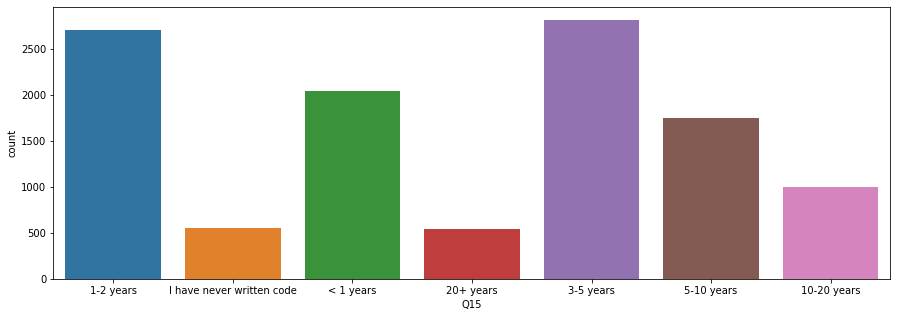

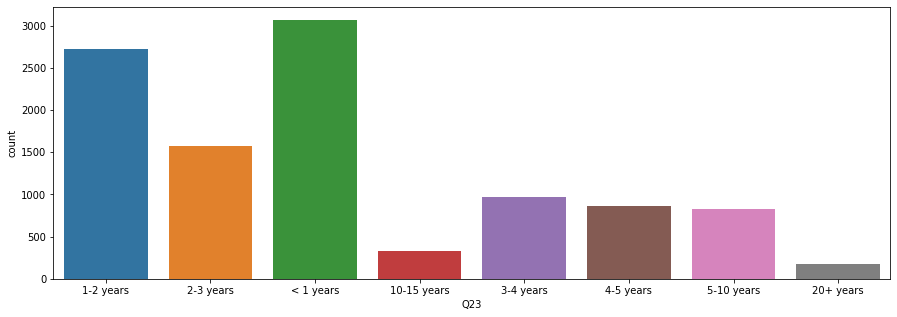

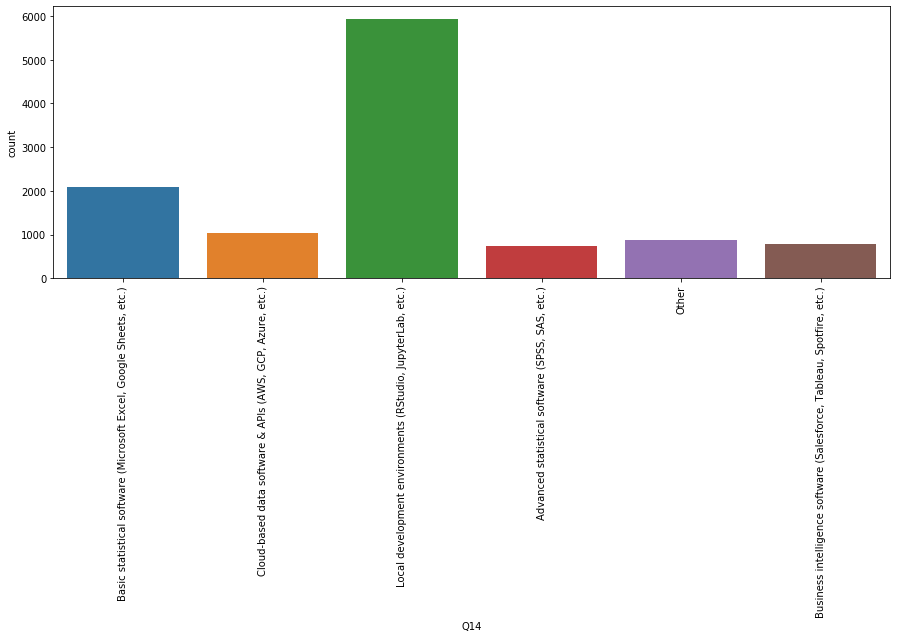

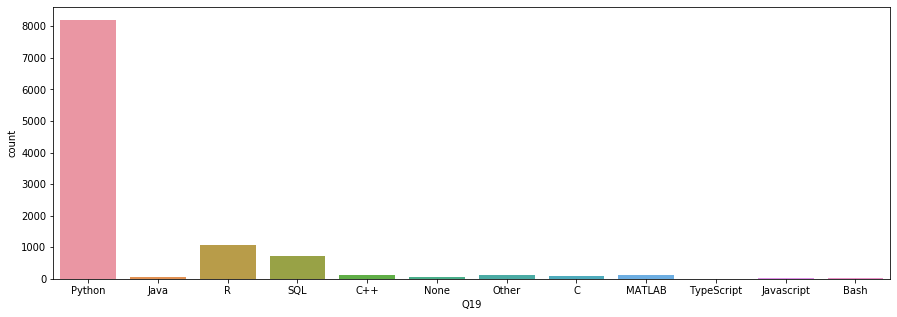

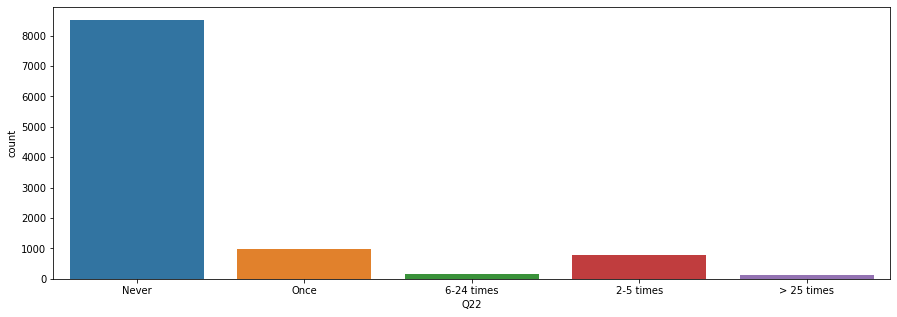

In [4]:
plt.figure(figsize=(15, 5))
sns.countplot(x=df.Q15)
plt.figure(figsize=(15, 5))
sns.countplot(x=df.Q23)
plt.figure(figsize=(15, 5))
sns.countplot(x=df.Q14)
plt.xticks(rotation=90)
plt.figure(figsize=(15, 5))
sns.countplot(x=df.Q19)
plt.figure(figsize=(15, 5))
sns.countplot(x=df.Q22)

In [0]:
Q15_23_sc = {'I have never written code': 0,
    '< 1 years': 0.5,
    '1-2 years': 1.5,
    '2-3 years': 2.5,
    '3-4 years': 3.5, 
    '3-5 years': 4,
    '4-5 years': 4.5,
    '5-10 years': 7.5,
    '10-15 years': 12.5,
    '10-20 years': 15,
    '20+ years': 20}
df['Q15'] = df['Q15'].map(Q15_23_sc)
df['Q23'] = df['Q23'].map(Q15_23_sc)
df.Q15 = df.Q15.fillna(df.Q15.median())
df.Q23 = df.Q23.fillna(df.Q23.median())



In [6]:
df.Q14 = df.Q14.fillna(df.Q14.mode()[0])
df.Q19 = df.Q19.fillna(df.Q19.mode()[0])
df.Q22 = df.Q22.fillna(df.Q22.mode()[0])
salary_unencoded = df
f = []

# This is a preparation only for feature importance in step2,
# I only choose the features without multiple choices and columns without "TEXT" to get correlation plot
# since those features are a huge amount
# and that would be hard to find feature importance.
for col in df.columns:
    if 'Part' not in col:
        if "TEXT" not in col:
            f.append(col)
ff = df.loc[:, f]
ff


,Time from Start to Finish (seconds),Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q10,Q11,Q14,Q15,Q19,Q22,Q23,Q10_Encoded,Q10_buckets
0,510,22-24,Male,France,Master’s degree,Software Engineer,"1000-9,999 employees",0,I do not know,"30,000-39,999",$0 (USD),"Basic statistical software (Microsoft Excel, G...",1.5,Python,Never,1.5,3,"30,000-39,999"
1,423,40-44,Male,India,Professional degree,Software Engineer,"> 10,000 employees",20+,"We have well established ML methods (i.e., mod...","5,000-7,499","> $100,000 ($USD)","Cloud-based data software & APIs (AWS, GCP, Az...",0.0,Python,Never,1.5,0,"0-9,999"
2,391,40-44,Male,Australia,Master’s degree,Other,"> 10,000 employees",20+,I do not know,"250,000-299,999","$10,000-$99,999","Local development environments (RStudio, Jupyt...",1.5,Python,Once,2.5,14,">250,000"
3,392,22-24,Male,India,Bachelor’s degree,Other,0-49 employees,0,No (we do not use ML methods),"4,000-4,999",$0 (USD),"Local development environments (RStudio, Jupyt...",0.5,Python,Never,0.5,0,"0-9,999"
4,470,50-54,Male,France,Master’s degree,Data Scientist,0-49 employees,3-4,"We have well established ML methods (i.e., mod...","60,000-69,999","$10,000-$99,999","Advanced statistical software (SPSS, SAS, etc.)",20.0,Java,Never,12.5,6,"60,000-69,999"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12490,176,22-24,Male,Other,Bachelor’s degree,Software Engineer,0-49 employees,0,No (we do not use ML methods),$0-999,$0 (USD),"Local development environments (RStudio, Jupyt...",4.0,Python,Never,1.5,0,"0-9,999"
12491,186,18-21,Male,India,Doctoral degree,Data Scientist,0-49 employees,0,We use ML methods for generating insights (but...,$0-999,$1-$99,"Local development environments (RStudio, Jupyt...",4.0,Python,Never,1.5,0,"0-9,999"
12492,346,22-24,Male,India,Bachelor’s degree,Data Scientist,50-249 employees,3-4,We use ML methods for generating insights (but...,"7,500-9,999",$100-$999,"Local development environments (RStudio, Jupyt...",4.0,Python,Never,1.5,0,"0-9,999"
12494,473,18-21,Male,India,Bachelor’s degree,Other,250-999 employees,3-4,I do not know,$0-999,$0 (USD),"Local development environments (RStudio, Jupyt...",1.5,Python,Never,1.5,0,"0-9,999"


###### **Converting features with 'Part' to numerical variables since those are multiple choice question, it's reasonable to have Nan in those features.**

In [0]:
for i in range(len(df.columns)):
    if 'Part' in df.columns[i]:
        df[df.columns[i]] = pd.get_dummies(df[df.columns[i]])

In [8]:
df.head(5)

,Time from Start to Finish (seconds),Q1,Q2,Q2_OTHER_TEXT,Q3,Q4,Q5,Q5_OTHER_TEXT,Q6,Q7,Q8,Q9_Part_1,Q9_Part_2,Q9_Part_3,Q9_Part_4,Q9_Part_5,Q9_Part_6,Q9_Part_7,Q9_Part_8,Q9_OTHER_TEXT,Q10,Q11,Q12_Part_1,Q12_Part_2,Q12_Part_3,Q12_Part_4,Q12_Part_5,Q12_Part_6,Q12_Part_7,Q12_Part_8,Q12_Part_9,Q12_Part_10,Q12_Part_11,Q12_Part_12,Q12_OTHER_TEXT,Q13_Part_1,Q13_Part_2,Q13_Part_3,Q13_Part_4,Q13_Part_5,...,Q32_Part_2,Q32_Part_3,Q32_Part_4,Q32_Part_5,Q32_Part_6,Q32_Part_7,Q32_Part_8,Q32_Part_9,Q32_Part_10,Q32_Part_11,Q32_Part_12,Q32_OTHER_TEXT,Q33_Part_1,Q33_Part_2,Q33_Part_3,Q33_Part_4,Q33_Part_5,Q33_Part_6,Q33_Part_7,Q33_Part_8,Q33_Part_9,Q33_Part_10,Q33_Part_11,Q33_Part_12,Q33_OTHER_TEXT,Q34_Part_1,Q34_Part_2,Q34_Part_3,Q34_Part_4,Q34_Part_5,Q34_Part_6,Q34_Part_7,Q34_Part_8,Q34_Part_9,Q34_Part_10,Q34_Part_11,Q34_Part_12,Q34_OTHER_TEXT,Q10_Encoded,Q10_buckets
0,510,22-24,Male,-1,France,Master’s degree,Software Engineer,-1,"1000-9,999 employees",0,I do not know,0,0,0,0,0,0,0,0,-1,"30,000-39,999",$0 (USD),1,0,0,1,0,0,0,1,1,0,0,0,-1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,-1,3,"30,000-39,999"
1,423,40-44,Male,-1,India,Professional degree,Software Engineer,-1,"> 10,000 employees",20+,"We have well established ML methods (i.e., mod...",1,1,1,1,0,0,0,0,-1,"5,000-7,499","> $100,000 ($USD)",0,0,0,1,0,1,1,1,0,0,0,0,-1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,"0-9,999"
2,391,40-44,Male,-1,Australia,Master’s degree,Other,0,"> 10,000 employees",20+,I do not know,0,0,0,0,0,0,0,0,-1,"250,000-299,999","$10,000-$99,999",0,0,0,0,0,0,1,1,1,1,0,0,-1,0,1,1,1,0,...,0,1,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,1,0,-1,0,0,0,0,0,0,0,0,1,0,0,0,-1,14,">250,000"
3,392,22-24,Male,-1,India,Bachelor’s degree,Other,1,0-49 employees,0,No (we do not use ML methods),0,0,0,0,0,0,0,0,-1,"4,000-4,999",$0 (USD),0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,"0-9,999"
4,470,50-54,Male,-1,France,Master’s degree,Data Scientist,-1,0-49 employees,3-4,"We have well established ML methods (i.e., mod...",0,0,1,0,0,1,0,0,-1,"60,000-69,999","$10,000-$99,999",0,0,0,0,0,1,0,1,1,0,0,0,-1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,-1,0,0,0,0,0,1,0,0,0,0,0,0,-1,0,1,0,0,0,0,1,0,0,0,0,0,-1,6,"60,000-69,999"


In [9]:
len(df.Q3.unique())

59

In [10]:
df.Q3.value_counts()

India                                                   2411
United States of America                                2101
Other                                                    686
Brazil                                                   528
Japan                                                    469
Russia                                                   422
Germany                                                  354
United Kingdom of Great Britain and Northern Ireland     328
Spain                                                    311
Canada                                                   290
France                                                   273
China                                                    233
Nigeria                                                  213
Australia                                                203
Italy                                                    192
Turkey                                                   167
Taiwan                  

###### **Converting all categorical features to numerical variables. For example, in feature Q3, we can see that number of countries range from 32 to 2411, and totally 59 different countries including "other". And we just need to convert them to be numerical features.**

In [0]:
df = pd.concat([df, pd.get_dummies(df[['Q2', 'Q3', 'Q5', 'Q8', 'Q14', 'Q19']])],axis=1)
df.drop(['Q2', 'Q3', 'Q5', 'Q8', 'Q14', 'Q19'],axis=1, inplace=True)

In [12]:
df.head(5)

,Time from Start to Finish (seconds),Q1,Q2_OTHER_TEXT,Q4,Q5_OTHER_TEXT,Q6,Q7,Q9_Part_1,Q9_Part_2,Q9_Part_3,Q9_Part_4,Q9_Part_5,Q9_Part_6,Q9_Part_7,Q9_Part_8,Q9_OTHER_TEXT,Q10,Q11,Q12_Part_1,Q12_Part_2,Q12_Part_3,Q12_Part_4,Q12_Part_5,Q12_Part_6,Q12_Part_7,Q12_Part_8,Q12_Part_9,Q12_Part_10,Q12_Part_11,Q12_Part_12,Q12_OTHER_TEXT,Q13_Part_1,Q13_Part_2,Q13_Part_3,Q13_Part_4,Q13_Part_5,Q13_Part_6,Q13_Part_7,Q13_Part_8,Q13_Part_9,...,Q3_Tunisia,Q3_Turkey,Q3_Ukraine,Q3_United Kingdom of Great Britain and Northern Ireland,Q3_United States of America,Q3_Viet Nam,Q5_Business Analyst,Q5_DBA/Database Engineer,Q5_Data Analyst,Q5_Data Engineer,Q5_Data Scientist,Q5_Other,Q5_Product/Project Manager,Q5_Research Scientist,Q5_Software Engineer,Q5_Statistician,Q8_I do not know,Q8_No (we do not use ML methods),Q8_We are exploring ML methods (and may one day put a model into production),"Q8_We have well established ML methods (i.e., models in production for more than 2 years)","Q8_We recently started using ML methods (i.e., models in production for less than 2 years)",Q8_We use ML methods for generating insights (but do not put working models into production),"Q14_Advanced statistical software (SPSS, SAS, etc.)","Q14_Basic statistical software (Microsoft Excel, Google Sheets, etc.)","Q14_Business intelligence software (Salesforce, Tableau, Spotfire, etc.)","Q14_Cloud-based data software & APIs (AWS, GCP, Azure, etc.)","Q14_Local development environments (RStudio, JupyterLab, etc.)",Q14_Other,Q19_Bash,Q19_C,Q19_C++,Q19_Java,Q19_Javascript,Q19_MATLAB,Q19_None,Q19_Other,Q19_Python,Q19_R,Q19_SQL,Q19_TypeScript
0,510,22-24,-1,Master’s degree,-1,"1000-9,999 employees",0,0,0,0,0,0,0,0,0,-1,"30,000-39,999",$0 (USD),1,0,0,1,0,0,0,1,1,0,0,0,-1,0,1,0,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,423,40-44,-1,Professional degree,-1,"> 10,000 employees",20+,1,1,1,1,0,0,0,0,-1,"5,000-7,499","> $100,000 ($USD)",0,0,0,1,0,1,1,1,0,0,0,0,-1,0,1,0,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,391,40-44,-1,Master’s degree,0,"> 10,000 employees",20+,0,0,0,0,0,0,0,0,-1,"250,000-299,999","$10,000-$99,999",0,0,0,0,0,0,1,1,1,1,0,0,-1,0,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
3,392,22-24,-1,Bachelor’s degree,1,0-49 employees,0,0,0,0,0,0,0,0,0,-1,"4,000-4,999",$0 (USD),0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
4,470,50-54,-1,Master’s degree,-1,0-49 employees,3-4,0,0,1,0,0,1,0,0,-1,"60,000-69,999","$10,000-$99,999",0,0,0,0,0,1,0,1,1,0,0,0,-1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


###### **Dealing with numerical range data and categorical data with rank(Q4:education), we take average of range to be the new data.**
###### **Q1 age** 
###### **Q6 size of company**
###### **Q7 number of employees work for data science**
###### **Q11 how much money spend on ml**
###### **Q22 use TPU**
###### **Q4 education** 

In [13]:
df.Q1.unique()

array(['22-24', '40-44', '50-54', '55-59', '30-34', '18-21', '35-39',
       '25-29', '45-49', '60-69', '70+'], dtype=object)

In [14]:
df.Q6.unique()

array(['1000-9,999 employees', '> 10,000 employees', '0-49 employees',
       '50-249 employees', '250-999 employees'], dtype=object)

**We see that both features Q1 and Q6 work for function below for converting them to be numerical features.**
**For example, "40-44" converts to 42(take average), "70+" converts to 70, "<20" converts to 20 and ">30" converts to 30.**

In [0]:
def range_split(dat1):
    if '-' in  dat1:
        x = dat1.split('-')
        return (float(x[0])+float(x[1]))/2
    if '+' in dat1:
        x = dat1.split('+')
        return float(x[0])
    if '<' in dat1:
        x = dat1.split('<')
        return float(x[0])
    if '> ' in dat1:
        x = dat1.split('>')
        return float(x[0])
    else:
        return dat1
df.Q1 = df.Q1.apply(range_split)
df['Q1'] = df['Q1'].astype(int)
df.Q7 = df.Q7.apply(range_split)
df['Q7'] = df['Q7'].astype(int)

In [16]:
df.Q6.unique()

array(['1000-9,999 employees', '> 10,000 employees', '0-49 employees',
       '50-249 employees', '250-999 employees'], dtype=object)

In [0]:
Q6_sc = {'0-49 employees': 25,
    '50-249 employees': 150,
    '250-999 employees': 625, 
    '1000-9,999 employees': 5500,
    '> 10,000 employees': 10000}
df['Q6'] = df['Q6'].map(Q6_sc)
df['Q6'] = df['Q6'].astype(int)



In [18]:
df.Q11.unique()

array(['$0 (USD)', '> $100,000 ($USD)', '$10,000-$99,999', '$100-$999',
       '$1000-$9,999', '$1-$99'], dtype=object)

In [0]:
Q11_sc = {'$0 (USD)': 0,
    '$1-$99': 50,
    '$100-$999': 550, 
    '$1000-$9,999': 5500,
    '$10,000-$99,999': 55000,
    '> $100,000 ($USD)': 100000}
df['Q11'] = df['Q11'].map(Q11_sc)
df['Q11'] = df['Q11'].astype(int)


In [20]:
df.Q22.unique()

array(['Never', 'Once', '6-24 times', '2-5 times', '> 25 times'],
      dtype=object)

In [0]:
Q22_sc = {'Never': 0,
    'Once': 1,
    '6-24 times': 15, 
    '2-5 times': 3.5,
    '> 25 times': 25}
df['Q22'] = df['Q22'].map(Q22_sc)
df['Q22'] = df['Q22'].astype(int)

**Lastly, we deal with Q4:education with ranking.**

In [22]:
df.Q4.unique()

array(['Master’s degree', 'Professional degree', 'Bachelor’s degree',
       'Doctoral degree',
       'Some college/university study without earning a bachelor’s degree',
       'I prefer not to answer', 'No formal education past high school'],
      dtype=object)

In [0]:
Q4_sc = {'I prefer not to answer': 0,
    'No formal education past high school': 1,
    'Some college/university study without earning a bachelor’s degree': 3, 
    'Professional degree': 2,
    'Bachelor’s degree': 4,
    'Master’s degree': 5,
    'Doctoral degree': 6}
df['Q4'] = df['Q4'].map(Q4_sc)
df['Q4'] = df['Q4'].astype(int)

In [24]:
df.head(5)


,Time from Start to Finish (seconds),Q1,Q2_OTHER_TEXT,Q4,Q5_OTHER_TEXT,Q6,Q7,Q9_Part_1,Q9_Part_2,Q9_Part_3,Q9_Part_4,Q9_Part_5,Q9_Part_6,Q9_Part_7,Q9_Part_8,Q9_OTHER_TEXT,Q10,Q11,Q12_Part_1,Q12_Part_2,Q12_Part_3,Q12_Part_4,Q12_Part_5,Q12_Part_6,Q12_Part_7,Q12_Part_8,Q12_Part_9,Q12_Part_10,Q12_Part_11,Q12_Part_12,Q12_OTHER_TEXT,Q13_Part_1,Q13_Part_2,Q13_Part_3,Q13_Part_4,Q13_Part_5,Q13_Part_6,Q13_Part_7,Q13_Part_8,Q13_Part_9,...,Q3_Tunisia,Q3_Turkey,Q3_Ukraine,Q3_United Kingdom of Great Britain and Northern Ireland,Q3_United States of America,Q3_Viet Nam,Q5_Business Analyst,Q5_DBA/Database Engineer,Q5_Data Analyst,Q5_Data Engineer,Q5_Data Scientist,Q5_Other,Q5_Product/Project Manager,Q5_Research Scientist,Q5_Software Engineer,Q5_Statistician,Q8_I do not know,Q8_No (we do not use ML methods),Q8_We are exploring ML methods (and may one day put a model into production),"Q8_We have well established ML methods (i.e., models in production for more than 2 years)","Q8_We recently started using ML methods (i.e., models in production for less than 2 years)",Q8_We use ML methods for generating insights (but do not put working models into production),"Q14_Advanced statistical software (SPSS, SAS, etc.)","Q14_Basic statistical software (Microsoft Excel, Google Sheets, etc.)","Q14_Business intelligence software (Salesforce, Tableau, Spotfire, etc.)","Q14_Cloud-based data software & APIs (AWS, GCP, Azure, etc.)","Q14_Local development environments (RStudio, JupyterLab, etc.)",Q14_Other,Q19_Bash,Q19_C,Q19_C++,Q19_Java,Q19_Javascript,Q19_MATLAB,Q19_None,Q19_Other,Q19_Python,Q19_R,Q19_SQL,Q19_TypeScript
0,510,23,-1,5,-1,5500,0,0,0,0,0,0,0,0,0,-1,"30,000-39,999",0,1,0,0,1,0,0,0,1,1,0,0,0,-1,0,1,0,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,423,42,-1,2,-1,10000,20,1,1,1,1,0,0,0,0,-1,"5,000-7,499",100000,0,0,0,1,0,1,1,1,0,0,0,0,-1,0,1,0,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,391,42,-1,5,0,10000,20,0,0,0,0,0,0,0,0,-1,"250,000-299,999",55000,0,0,0,0,0,0,1,1,1,1,0,0,-1,0,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
3,392,23,-1,4,1,25,0,0,0,0,0,0,0,0,0,-1,"4,000-4,999",0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
4,470,52,-1,5,-1,25,3,0,0,1,0,0,1,0,0,-1,"60,000-69,999",55000,0,0,0,0,0,1,0,1,1,0,0,0,-1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


## **2.DATA EXPLORATION**
######**a).**

Text(0, 0.5, 'Q10_Encoded(salary_label)')

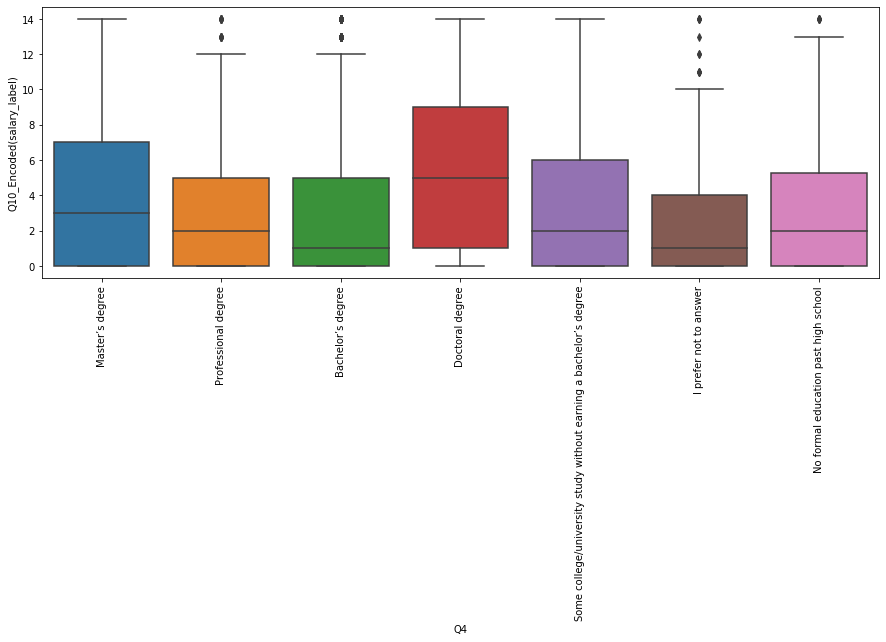

In [25]:
plt.figure(figsize=(15,5))
Edu_plot = sns.boxplot(x=salary_unencoded.Q4, y=salary_unencoded.Q10_Encoded)
Edu_plot.set_xticklabels(Edu_plot.get_xticklabels(), rotation=90)
plt.ylabel("Q10_Encoded(salary_label)")

###### **It's obvious that Doctoral degree has the highest values in both the 3rd quantile and median, Master's degree has the second highest values in both the 3rd quantile and median. Therefore, we can predict that education is highly correlated with salary.**

[Text(0, 0.5, 'count'), Text(0.5, 0, 'Yearly Compensation for Female')]

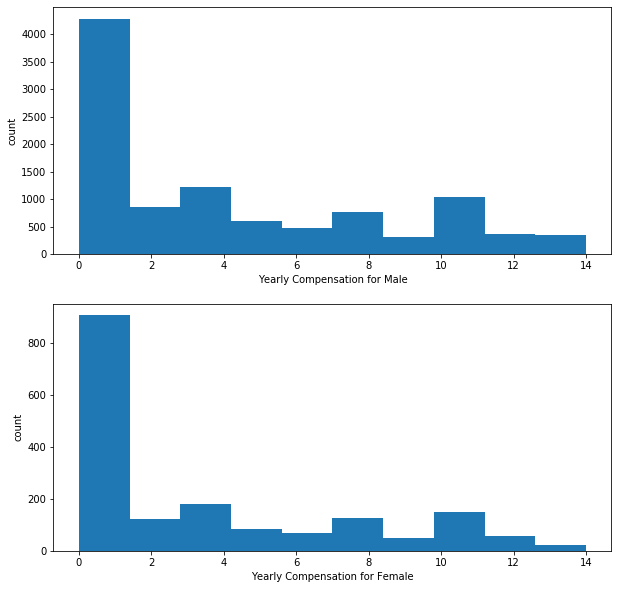

In [44]:
fig, ax = plt.subplots(2, figsize=(10,10))
ax[0].hist(salary_unencoded[salary_unencoded["Q2"]=="Male"]["Q10_Encoded"])
ax[0].set(xlabel="Yearly Compensation for Male", ylabel="count")
ax[1].hist(salary_unencoded[salary_unencoded["Q2"]=="Female"]["Q10_Encoded"])
ax[1].set(xlabel="Yearly Compensation for Female", ylabel="count")

###### **Distribution of salary for both Male and Female are almost the same, so it may not have correlation between gendar and yearly compensation.**

Text(0.5, 0, 'Country')

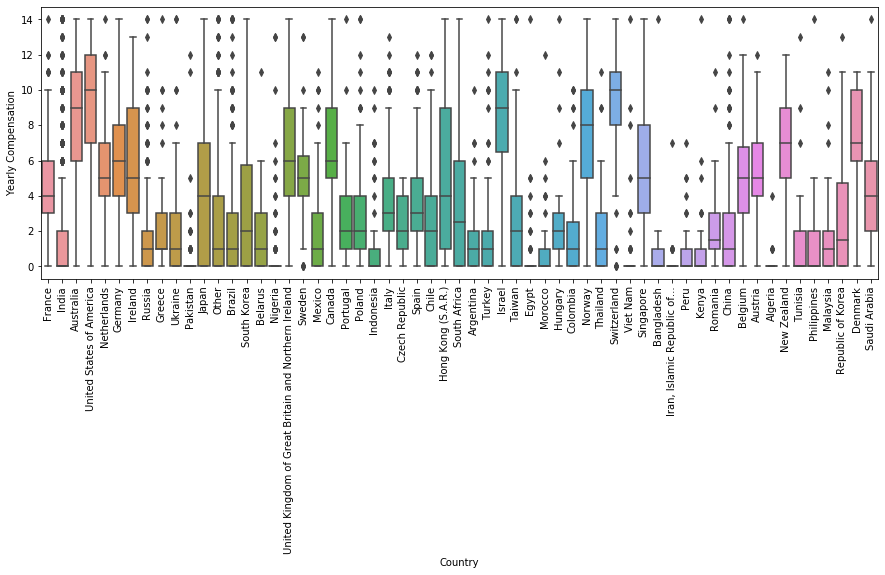

In [27]:
plt.figure(figsize=(15,5))
sns.boxplot(x=salary_unencoded.Q3, y=salary_unencoded.Q10_Encoded)
plt.xticks(rotation=90)
plt.ylabel("Yearly Compensation")
plt.xlabel("Country")

######**It's obviously that developed countries(USA, Australia, Canada, Switzerland and so on) have higher median yearly compensation than other developing countries. There exist some correlations between yearly compensation and countries.**
######**b).**

In [28]:
df.head(5)

,Time from Start to Finish (seconds),Q1,Q2_OTHER_TEXT,Q4,Q5_OTHER_TEXT,Q6,Q7,Q9_Part_1,Q9_Part_2,Q9_Part_3,Q9_Part_4,Q9_Part_5,Q9_Part_6,Q9_Part_7,Q9_Part_8,Q9_OTHER_TEXT,Q10,Q11,Q12_Part_1,Q12_Part_2,Q12_Part_3,Q12_Part_4,Q12_Part_5,Q12_Part_6,Q12_Part_7,Q12_Part_8,Q12_Part_9,Q12_Part_10,Q12_Part_11,Q12_Part_12,Q12_OTHER_TEXT,Q13_Part_1,Q13_Part_2,Q13_Part_3,Q13_Part_4,Q13_Part_5,Q13_Part_6,Q13_Part_7,Q13_Part_8,Q13_Part_9,...,Q3_Tunisia,Q3_Turkey,Q3_Ukraine,Q3_United Kingdom of Great Britain and Northern Ireland,Q3_United States of America,Q3_Viet Nam,Q5_Business Analyst,Q5_DBA/Database Engineer,Q5_Data Analyst,Q5_Data Engineer,Q5_Data Scientist,Q5_Other,Q5_Product/Project Manager,Q5_Research Scientist,Q5_Software Engineer,Q5_Statistician,Q8_I do not know,Q8_No (we do not use ML methods),Q8_We are exploring ML methods (and may one day put a model into production),"Q8_We have well established ML methods (i.e., models in production for more than 2 years)","Q8_We recently started using ML methods (i.e., models in production for less than 2 years)",Q8_We use ML methods for generating insights (but do not put working models into production),"Q14_Advanced statistical software (SPSS, SAS, etc.)","Q14_Basic statistical software (Microsoft Excel, Google Sheets, etc.)","Q14_Business intelligence software (Salesforce, Tableau, Spotfire, etc.)","Q14_Cloud-based data software & APIs (AWS, GCP, Azure, etc.)","Q14_Local development environments (RStudio, JupyterLab, etc.)",Q14_Other,Q19_Bash,Q19_C,Q19_C++,Q19_Java,Q19_Javascript,Q19_MATLAB,Q19_None,Q19_Other,Q19_Python,Q19_R,Q19_SQL,Q19_TypeScript
0,510,23,-1,5,-1,5500,0,0,0,0,0,0,0,0,0,-1,"30,000-39,999",0,1,0,0,1,0,0,0,1,1,0,0,0,-1,0,1,0,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,423,42,-1,2,-1,10000,20,1,1,1,1,0,0,0,0,-1,"5,000-7,499",100000,0,0,0,1,0,1,1,1,0,0,0,0,-1,0,1,0,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,391,42,-1,5,0,10000,20,0,0,0,0,0,0,0,0,-1,"250,000-299,999",55000,0,0,0,0,0,0,1,1,1,1,0,0,-1,0,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
3,392,23,-1,4,1,25,0,0,0,0,0,0,0,0,0,-1,"4,000-4,999",0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
4,470,52,-1,5,-1,25,3,0,0,1,0,0,1,0,0,-1,"60,000-69,999",55000,0,0,0,0,0,1,0,1,1,0,0,0,-1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


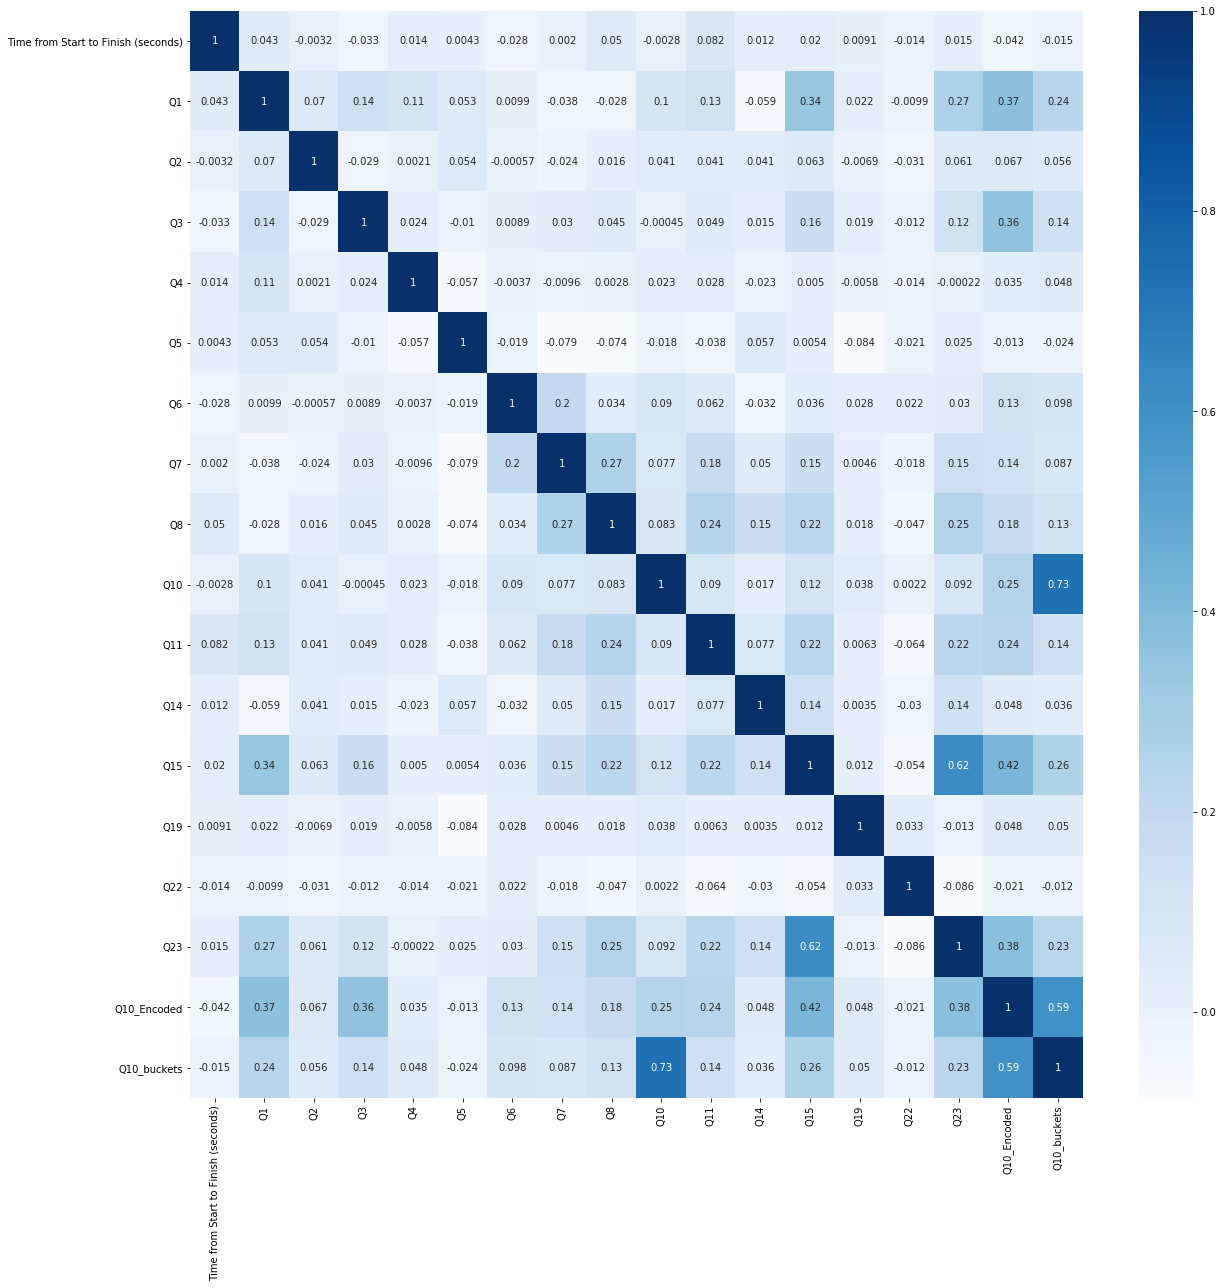

In [29]:
le = preprocessing.LabelEncoder()
for col in ff.columns:
    ff[col] = le.fit_transform(ff[col])
f, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(ff.corr(), cmap="Blues", annot=True)

######**I encoded all the feature and plot the correlation matrix. I found that features Q1(age), Q3(country), Q15(How long write code analyze code), Q23(How long using machine learning) and Q11(Money spent on ml) are most correlated with Q10_Encoded(target).**

## **3.Feature selection**
###### **Doing feature engineering in the model will choosing the right features will not only greatly improve its predictive power, but it also has the flexibility to use models that run faster and are easier to understand with less complexity.**
###### **Here, I use Lasso regression to do feature selection, and find alpha corresponding to lowest mse as a penalty. After fit the lasso regression, I extracted coefficient(weight) with respect to each feature of it. If coefficient is 0, we would drop features correspondeding to zero coefficients. because lasso force weak feature have zero coefficient(weight), feature with zero coefficient(weight) cannot effect model.**

In [0]:
xx=[]
for col in df.columns:
    if 'Q10' not in col:
        xx.append(col)
x = df.loc[:, xx].values # all features without label Q10.
y = df.loc[:, "Q10_Encoded"].values

In [0]:
x = StandardScaler().fit_transform(x)
x1= np.ones(shape=(x.shape[0], x.shape[1] + 1))
x1[:, 1:] = x
x_train, x_test, y_train, y_test = train_test_split(x1, y, 
                                                    test_size = 0.2, random_state=42)
Alpha = [0.0005, 0.001, 0.005, 0.01, 0.015, 0.2, 0.3, 0.5, 1]
mse = []
for alp in Alpha:
   lasso = Lasso(alpha=alp)
   clf=lasso.fit(x_train, y_train)
   y_pred = clf.predict(x_test)
   mse.append(mean_squared_error(y_test, y_pred))
indd = mse.index(min(mse))

In [32]:
x = (x-x.mean(axis=0))/x.std(axis=0)
lasso = Lasso(alpha=Alpha[indd])
clf=lasso.fit(x, y)
print(clf.coef_)

[ 0.00000000e+00  5.79748094e-01  2.13089246e-02  4.89490558e-03
 -1.95528431e-02  2.41798827e-01  9.33483762e-02  7.47347603e-02
 -0.00000000e+00  1.36611772e-01  0.00000000e+00  0.00000000e+00
 -3.68162388e-02  1.72112843e-02 -3.58130391e-03 -0.00000000e+00
  4.79459641e-01  3.83007103e-02  5.68876875e-02 -0.00000000e+00
 -0.00000000e+00 -8.82468865e-03 -1.08736677e-01  2.62993808e-05
  8.04263870e-02 -3.77437931e-02 -0.00000000e+00  0.00000000e+00
 -5.54570805e-03 -0.00000000e+00  0.00000000e+00  7.68966156e-02
 -2.14568142e-03 -5.34967297e-02 -1.36728529e-02 -3.79130849e-02
  1.09759881e-01 -1.57012145e-02 -5.23454521e-03 -4.35472683e-02
  0.00000000e+00 -2.92880029e-02 -0.00000000e+00  0.00000000e+00
  0.00000000e+00 -3.38948698e-02  0.00000000e+00 -9.19133226e-02
  4.26257792e-03  4.11418574e-01  3.13918672e-03 -1.41092664e-02
  0.00000000e+00  6.42741676e-03 -6.05498275e-02 -2.91952261e-02
 -4.67741765e-02  3.16528992e-02 -3.21335213e-02  2.35051708e-02
 -2.78284457e-03  0.00000

In [0]:
index1=[]
for i in range(len(clf.coef_)):
    if clf.coef_[i] == 0:
        index1.append(i)

index1=df.iloc[:,index1].columns

In [0]:
index1=index1.tolist()

###### **I will only select the features that not exist in the index1, because lasso regression penalizer the features in index1 to be zero with lowest mse, which means drop the features corresponding to zero coefficient(weight) will enhance the prediction accuracy and interpretability of the statistical model it produces**

In [35]:
index1

['Time from Start to Finish (seconds)',
 'Q9_Part_2',
 'Q9_Part_4',
 'Q9_Part_5',
 'Q9_OTHER_TEXT',
 'Q12_Part_2',
 'Q12_Part_3',
 'Q12_Part_9',
 'Q12_Part_10',
 'Q12_Part_12',
 'Q12_OTHER_TEXT',
 'Q13_Part_10',
 'Q13_Part_12',
 'Q13_OTHER_TEXT',
 'Q14_Part_1_TEXT',
 'Q14_Part_3_TEXT',
 'Q16_Part_2',
 'Q16_Part_11',
 'Q17_Part_2',
 'Q17_Part_3',
 'Q17_Part_4',
 'Q17_Part_6',
 'Q17_Part_7',
 'Q17_Part_9',
 'Q17_Part_11',
 'Q17_Part_12',
 'Q17_OTHER_TEXT',
 'Q18_Part_2',
 'Q18_Part_4',
 'Q18_Part_9',
 'Q18_Part_11',
 'Q19_OTHER_TEXT',
 'Q20_Part_5',
 'Q20_Part_8',
 'Q20_Part_11',
 'Q20_OTHER_TEXT',
 'Q21_Part_2',
 'Q21_Part_4',
 'Q21_OTHER_TEXT',
 'Q24_Part_1',
 'Q24_Part_4',
 'Q24_Part_5',
 'Q24_Part_6',
 'Q24_Part_7',
 'Q24_Part_8',
 'Q24_Part_10',
 'Q24_OTHER_TEXT',
 'Q25_Part_1',
 'Q25_Part_3',
 'Q25_Part_7',
 'Q25_Part_8',
 'Q25_OTHER_TEXT',
 'Q26_Part_4',
 'Q26_Part_7',
 'Q26_OTHER_TEXT',
 'Q27_Part_3',
 'Q27_OTHER_TEXT',
 'Q28_Part_1',
 'Q28_Part_2',
 'Q28_Part_5',
 'Q28_Part_6',


In [36]:
df.drop(columns=index1, axis=1, inplace=True)
df

,Q1,Q2_OTHER_TEXT,Q4,Q5_OTHER_TEXT,Q6,Q7,Q9_Part_1,Q9_Part_3,Q9_Part_6,Q9_Part_7,Q9_Part_8,Q10,Q11,Q12_Part_1,Q12_Part_4,Q12_Part_5,Q12_Part_6,Q12_Part_7,Q12_Part_8,Q12_Part_11,Q13_Part_1,Q13_Part_2,Q13_Part_3,Q13_Part_4,Q13_Part_5,Q13_Part_6,Q13_Part_7,Q13_Part_8,Q13_Part_9,Q13_Part_11,Q14_Part_2_TEXT,Q14_Part_4_TEXT,Q14_Part_5_TEXT,Q14_OTHER_TEXT,Q15,Q16_Part_1,Q16_Part_3,Q16_Part_4,Q16_Part_5,Q16_Part_6,...,Q3_Portugal,Q3_Republic of Korea,Q3_Romania,Q3_Russia,Q3_Saudi Arabia,Q3_Singapore,Q3_South Africa,Q3_South Korea,Q3_Spain,Q3_Sweden,Q3_Taiwan,Q3_Thailand,Q3_Tunisia,Q3_Turkey,Q3_Ukraine,Q3_United Kingdom of Great Britain and Northern Ireland,Q3_Viet Nam,Q5_Business Analyst,Q5_DBA/Database Engineer,Q5_Data Analyst,Q5_Data Engineer,Q5_Data Scientist,Q5_Product/Project Manager,Q5_Research Scientist,Q5_Software Engineer,Q5_Statistician,Q8_I do not know,Q8_No (we do not use ML methods),"Q14_Business intelligence software (Salesforce, Tableau, Spotfire, etc.)","Q14_Cloud-based data software & APIs (AWS, GCP, Azure, etc.)","Q14_Local development environments (RStudio, JupyterLab, etc.)",Q14_Other,Q19_Bash,Q19_C,Q19_Java,Q19_Other,Q19_Python,Q19_R,Q19_SQL,Q19_TypeScript
0,23,-1,5,-1,5500,0,0,0,0,0,0,"30,000-39,999",0,1,1,0,0,0,1,0,0,1,0,1,0,1,0,1,0,0,1,1,1,-1,1.5,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
1,42,-1,2,-1,10000,20,1,1,0,0,0,"5,000-7,499",100000,0,1,0,1,1,1,0,0,1,0,1,0,1,0,1,0,0,1,1,0,-1,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
2,42,-1,5,0,10000,20,0,0,0,0,0,"250,000-299,999",55000,0,0,0,0,1,1,0,0,1,1,1,0,0,0,0,0,0,1,0,1,-1,1.5,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0
3,23,-1,4,1,25,0,0,0,0,0,0,"4,000-4,999",0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,-1,0.5,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0
4,52,-1,5,-1,25,3,0,1,1,0,0,"60,000-69,999",55000,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,1,-1,20.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12490,23,-1,4,-1,25,0,0,0,0,0,0,$0-999,0,0,1,0,1,1,1,0,0,1,0,0,0,0,0,0,1,0,1,1,1,-1,4.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0
12491,19,-1,6,-1,25,0,0,0,1,0,0,$0-999,50,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,-1,4.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
12492,23,-1,4,-1,150,3,1,0,0,0,0,"7,500-9,999",550,1,0,0,1,0,0,0,1,1,1,1,1,0,1,1,0,0,1,1,1,-1,4.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
12494,19,-1,4,-1,625,3,0,0,0,0,0,$0-999,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,-1,1.5,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0


## **4 and 5. Model implementation and Model tuning.**

###### **I implement 10 fold cross validation on ordinary multiclass logistic regression.**
###### **I create 14 distinct binary logistic regression classfiers and each one is to classify different class. For example, the first classifier classify 1 to label <= 0 and 0 to otherwise, the second classifier classify 1 to label <= 1 and 0 to otherwise, the third classifier classify 1 to label <= 2 and 0 to otherwise, the last one classifier classify 1 to label <= 13 and 0 to label 14. After that, I use those to fit validation set, and extract each 14 classifier of probability of belonging to each of salary buckets and combine into a matrix. Then I use the right column minus the left adjacent column begining from last second column to the second column. Finally, I replace the last column of matrix by using 1 minus sum of other columns by axis=1. Now, each row of matrix has 14 number within 0 to 1, which represents the probability of belonging to each of the salary buckets. column number corresponding to highest number in each row is the predicted label in each row(data). And this is how I implement ordinary multiclass logistic regression.**

In [37]:
acc = []
def y_label(y, c):
    return (y <= c).astype(int)
skf = StratifiedKFold(n_splits=10)
kfold = KFold(n_splits=10)
kfold.get_n_splits(x_train)
np_idx = 0
for train_index, test_index in kfold.split(x_train):
    p_opti = np.zeros((x_train[test_index].shape[0],15))
    for i in range(14):
        lr = LogisticRegression(max_iter=5000)
        clf = lr.fit(x_train[train_index], y_label(y_train[train_index], i))
        prob = clf.predict_proba(x_train[test_index])
        p_opti[:, i] = prob[:, 1]
    for i in range(13, 0, -1):
        p_opti[:, i] = p_opti[:, i]-p_opti[:, i-1]
    p_opti[:, -1] = 1-np.sum(p_opti[:, 0:-1], axis=1)
    predictions = p_opti.argmax(axis=1)
    acc.append(100 * np.mean(predictions == y_train[test_index]))
    np_idx += 1
    print("Fold {}: Accuracy: {}%".format(np_idx, round(100 * np.mean(predictions == y_train[test_index]),3)))
print ("Average accuracy on cross validation without tuning: {}%({}%)".format(round(np.mean(acc),3),round(np.std(acc),3)))

Fold 1: Accuracy: 35.918%
Fold 2: Accuracy: 34.592%
Fold 3: Accuracy: 38.265%
Fold 4: Accuracy: 36.633%
Fold 5: Accuracy: 37.041%
Fold 6: Accuracy: 36.327%
Fold 7: Accuracy: 36.939%
Fold 8: Accuracy: 37.959%
Fold 9: Accuracy: 34.898%
Fold 10: Accuracy: 37.857%
Average accuracy on cross validation without tuning: 36.643%(1.182%)


###### **Average accuracy is 36.694% with standard deviation 1.089%. The average accuracy is not high, so this model has high bias. And the low standard deviation means the low variance. Based on bias-variance tradeoff, this is due to missing the relevant relations between features and target outputs.**
###### **I will doing grid search do find optimal hyperparameters by tunning C and solver. I  choose 10 differnent C between 0.001 and 0.01 this time since I had tried 10 differnt C before, and the optimal one was always among 0.01 and 0.001.**
###### **I use accuracy as a metric for comparing model performance sicne cost of both FN and FP are not high. Tring to find hyperparameters corresponding to the highest accuracy in each binary logistic regression model.**

In [38]:
# model = LogisticRegression()
# scaler = StandardScaler()
# kfold = KFold(n_splits=10)
# kfold.get_n_splits(x_train)


# def y_label(y, c):
#     return (y <= c).astype(int)
# for i in range(14):
#     best_model = model
#     best_params = {}
#     best_accuracy = 0
#     best_std = 0    
#     for C in [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01]:
#         for solver in ['newton-cg','lbfgs','liblinear','sag']:
            
#             accuracy = np.zeros(10)
#             np_idx = 0  
#             for train_idx, test_idx in kfold.split(x_train):
#                 model = LogisticRegression(C=C, solver=solver)
#                 X_Train, X_Test = x_train[train_idx], x_train[test_idx]
#                 y_Train, y_Test = y_train[train_idx], y_train[test_idx]

#                 X_Train = scaler.fit_transform(X_Train)
#                 X_Test = scaler.transform(X_Test)

#                 model.fit(X_Train, y_label(y_Train, i))

#                 predictions = model.predict(X_Test)

#                 TN = confusion_matrix(y_label(y_Test, i), predictions)[0][0]
#                 FP = confusion_matrix(y_label(y_Test, i), predictions)[0][1]
#                 FN = confusion_matrix(y_label(y_Test, i), predictions)[1][0]
#                 TP = confusion_matrix(y_label(y_Test, i), predictions)[1][1]
#                 total = TN + FP + FN + TP
#                 ACC = (TP + TN) / float(total)

#                 accuracy[np_idx] = ACC*100
#                 np_idx += 1

#             if np.mean(accuracy) > best_accuracy:
#                 best_model = model
#                 best_params = {'C':C, 'solver':solver}
#                 best_accuracy = np.mean(accuracy)
#                 best_std = np.std(accuracy)

#     print (best_params)
#     print ("Best Score: {}%({}%)".format(round(best_accuracy,3),round(best_std,3)))      

#     print ("\nThe optimal log model uses C={}, and a {} solver, and has a cross validation score of {}% with a standard deviation of {}%".format(best_params['C'],best_params['solver'],round(best_accuracy,3),round(best_std,3)))

{'C': 0.002, 'solver': 'newton-cg'}
Best Score: 79.367%(0.987%)

The optimal log model uses C=0.002, and a newton-cg solver, and has a cross validation score of 79.367% with a standard deviation of 0.987%
{'C': 0.001, 'solver': 'lbfgs'}
Best Score: 80.765%(0.98%)

The optimal log model uses C=0.001, and a lbfgs solver, and has a cross validation score of 80.765% with a standard deviation of 0.98%
{'C': 0.002, 'solver': 'liblinear'}
Best Score: 82.469%(1.121%)

The optimal log model uses C=0.002, and a liblinear solver, and has a cross validation score of 82.469% with a standard deviation of 1.121%
{'C': 0.002, 'solver': 'liblinear'}
Best Score: 83.204%(1.073%)

The optimal log model uses C=0.002, and a liblinear solver, and has a cross validation score of 83.204% with a standard deviation of 1.073%
{'C': 0.004, 'solver': 'newton-cg'}
Best Score: 84.796%(0.805%)

The optimal log model uses C=0.004, and a newton-cg solver, and has a cross validation score of 84.796% with a standard devia

###### **After doing grid search, I found these hyperparameters are the best hyparameters with respect to 14 binary classification model(logistic regression). And I will use the optimal hyparameters to test on multi-class ordinary logistic regression to see if it will be better than before.**

In [0]:
c=[0.002,0.001,0.002,0.002,0.004,0.08,0.004,0.006,0.007,0.004,0.003,0.008,0.002,0.004]
Solver = ['newton-cg', 'lbfgs', 'liblinear', 'liblinear', 'newton-cg', 'newton-cg', 'newton-cg', 'lbfgs', 'newton-cg','liblinear','liblinear','newton-cg','newton-cg','newton-cg']

In [40]:
acc = []
np_idx = 0

def y_label(y, c):
    return (y <= c).astype(int)
skf = StratifiedKFold(n_splits=10)
kfold = KFold(n_splits=10)
kfold.get_n_splits(x_train)
for train_index, test_index in kfold.split(x_train):
    p_opti = np.zeros((x_train[test_index].shape[0],15))
    for i in range(14):
        lr = LogisticRegression(C=c[i], solver=Solver[i], max_iter=5000)
        clf = lr.fit(x_train[train_index], y_label(y_train[train_index], i))
        prob = clf.predict_proba(x_train[test_index])
        p_opti[:, i] = prob[:, 1]
    for i in range(13, 0, -1):
        p_opti[:, i] = p_opti[:, i]-p_opti[:, i-1]
    p_opti[:, -1] = 1-np.sum(p_opti[:, 0:-1], axis=1)
    predictions = p_opti.argmax(axis=1)
    acc.append(100 * np.mean(predictions == y_train[test_index]))
    np_idx += 1
    print("Fold {}: Accuracy: {}%".format(np_idx, round(100 * np.mean(predictions == y_train[test_index]),3)))
print ("Average accuracy on cross validaiton with optimal hyperparameters is: {}%({}%)".format(round(np.mean(acc),3),round(np.std(acc),3)))

Fold 1: Accuracy: 37.551%
Fold 2: Accuracy: 34.694%
Fold 3: Accuracy: 37.245%
Fold 4: Accuracy: 38.673%
Fold 5: Accuracy: 37.857%
Fold 6: Accuracy: 36.531%
Fold 7: Accuracy: 37.347%
Fold 8: Accuracy: 39.592%
Fold 9: Accuracy: 33.878%
Fold 10: Accuracy: 38.265%
Average accuracy on cross validaiton with optimal hyperparameters is: 37.163%(1.654%)


###### **We see that avaerage accuracy increase a little bit after using the optimal hyperparameters based on grid search.(37.163%>36.643%)**

## **6.Testing & Discussion**

In [41]:
p_opti = np.zeros((x_test.shape[0],15))
for i in range(14):
    lr = LogisticRegression(C=c[i], solver=Solver[i], max_iter=5000)
    clf = lr.fit(x_train, y_label(y_train, i))
    prob = clf.predict_proba(x_test)
    p_opti[:, i] = prob[:, 1]
for i in range(13, 0, -1):
    p_opti[:, i] = p_opti[:, i]-p_opti[:, i-1]
p_opti[:, -1] = 1-np.sum(p_opti[:, 0:-1], axis=1)
predictions = p_opti.argmax(axis=1)
print ("Accuracy on test set with optimal hyperparameters is: {}%".format(round(100 * np.mean(predictions == y_test),3)))

Accuracy on test set with optimal hyperparameters is: 34.735%


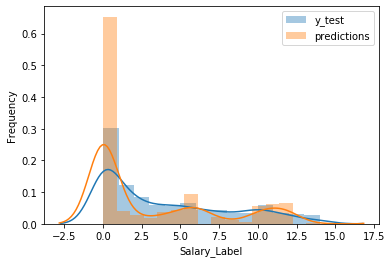

In [42]:
sns.distplot(y_test, label="y_test")
sns.distplot(predictions, label="predictions")
plt.xlabel("Salary_Label")
plt.ylabel("Frequency")
plt.legend()

###### **Accuracy on test set is slightly lower than accuracy on training set.**
###### **This is underfitting, model is still too simple since we are doing 15-classification.**
###### **According to the distribution of y_test and prediction, I found that predcition on label 0 are more than a half, and in y_test, proportion of label 0 is around 30%. And in y_test, both label 1 and label 2 are around 10%. In prediction, both frequency of them are less than 5%. Therefore, this model is oversimplify and leading to underfitting.**
###### **Improvement:**
###### **1. Better data cleanning method or better data quality.**
###### **2. More complexity of model.**
###### **3. Trying to tune more different value of hyperparameters.**
###### **4. Spend more time on training process until cost function converge completely.**